# Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.utils import class_weight


# fix random seed for reproducibility
np.random.seed(42)

/home/brad/anaconda3/envs/xenas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/brad/anaconda3/envs/xenas/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from   plotly.offline    import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from   sklearn.metrics   import confusion_matrix

#Matplotlib inline
%matplotlib inline

# run at the start of every ipython notebook to use plotly.offline
# this injects the plotly.js source files into the notebook
init_notebook_mode(connected=True) 


In [3]:
#need my printf 
def printf(format, *values):
    print(format % values )

In [4]:
%%time
# Load samples and labels
X = pd.read_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression")
print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

X: samples=19249 genes=58581
Y: samples=19131 labels=6
CPU times: user 156 ms, sys: 1.04 s, total: 1.2 s
Wall time: 1.23 s


In [5]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19115 samples with non-null labels


In [6]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19115,19115,19115,19115,18957,19115,19115,19115.000000,19115.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1835,9185,10447,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550876,20.659273
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497418,12.419497
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [7]:
# Convert classes into numbers
encoder.fit(Y["primary_site"].values)
classes = encoder.transform(Y["primary_site"])
print("Total classes for stratification:", len(set(classes)))
class_labels = encoder.classes_
print(class_labels)

Total classes for stratification: 46
['Adipose Tissue' 'Adrenal Gland' 'Adrenal gland' 'Bile duct' 'Bladder'
 'Blood' 'Blood Vessel' 'Bone Marrow' 'Brain' 'Breast' 'Cervix'
 'Cervix Uteri' 'Colon' 'Endometrium' 'Esophagus' 'Eye' 'Fallopian Tube'
 'Head and Neck region' 'Heart' 'Kidney' 'Lining of body cavities' 'Liver'
 'Lung' 'Lymphatic tissue' 'Muscle' 'Nerve' 'Ovary' 'Pancreas'
 'Paraganglia' 'Pituitary' 'Prostate' 'Rectum' 'Salivary Gland' 'Skin'
 'Small Intestine' 'Soft tissue,Bone' 'Spleen' 'Stomach'
 'SympatheticÊNervous System' 'Testis' 'Thymus' 'Thyroid' 'Thyroid Gland'
 'Uterus' 'Vagina' 'White blood cell']


In [8]:
X[0:20000:3000].head()

sample,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,0.0,0.0,0.0,7.3524,6.1269,1.9343,14.432300,6.5937,4.6431,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-145LS-1226-SM-5Q5D9,0.0,0.0,0.0,6.4274,6.8759,1.0336,18.091999,6.6323,2.0501,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-X8HC-0126-SM-4E3JW,0.0,0.0,0.0,7.1905,7.3925,1.8230,13.508500,4.3042,11.9234,1.823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1821,0.0000
TCGA-24-1436-01,0.0,0.0,0.0,7.8777,8.3273,0.0000,14.739500,6.5108,5.7128,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.6946
TCGA-BG-A3PP-01,0.0,0.0,0.0,5.4354,5.4573,0.0000,13.103800,5.9861,7.4694,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000


In [9]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X8HC-0126-SM-4E3JW,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1436-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BG-A3PP-01,Uterine Corpus Endometrioid Carcinoma,Uterine Corpus Endometrioid Carcinoma,Endometrium,Primary Tumor,Female,TCGA,Tumor,1,13


In [10]:
print ('X shape', X.shape)
print (X.columns[0:10])
genes=np.array (X.columns[:])
print (genes[0:10])
print( type(genes))

X shape (19115, 58581)
Index(['5S_rRNA', '5_8S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M',
       'A2M-AS1', 'A2ML1', 'A2ML1-AS1'],
      dtype='object', name='sample')
['5S_rRNA' '5_8S_rRNA' '7SK' 'A1BG' 'A1BG-AS1' 'A1CF' 'A2M' 'A2M-AS1'
 'A2ML1' 'A2ML1-AS1']
<class 'numpy.ndarray'>


In [11]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19115, 5172)


In [12]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

In [13]:
# Create a multi-class one hot output with tumor/normal + primary site
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(
    tumor_normal_one_hot.values.reshape(tumor_normal_one_hot.shape[0],-1), 
    primary_site_one_hot, axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot)


(19115, 47)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [14]:
# create expanded onehot with cell, plus tumor celltype

Y_celltumor = Y["primary_site_value"] + Y["tumor_normal_value"]*46
Y_celltumor_onehot = np_utils.to_categorical(Y_celltumor)
print(Y_celltumor[0:10])
print(Y_celltumor_onehot.shape)
print(Y_celltumor_onehot[0:10])
#print(Y["primary_site_value"])


id
GTEX-1117F-0226-SM-5GZZ7     0
GTEX-1117F-0426-SM-5EGHI    24
GTEX-1117F-0526-SM-5EGHJ     6
GTEX-1117F-0626-SM-5N9CS     6
GTEX-1117F-0726-SM-5GIEN    18
GTEX-1117F-1326-SM-5EGHH     0
GTEX-1117F-2226-SM-5N9CH    26
GTEX-1117F-2426-SM-5EGGH    43
GTEX-1117F-2826-SM-5GZXL     9
GTEX-1117F-3026-SM-5GZYU    32
dtype: int64
(19115, 92)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [16]:
if(1) :  ## Expanded Data - 92 cell types
    # Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
    # proportions of each tissue type in the train and test sets
    for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y_celltumor_onehot[train_index], Y_celltumor_onehot[test_index]
#        classes_train, classes_test = Y_celltumor[train_index], Y_celltumor[test_index]
        Y_train, Y_test = Y_celltumor[train_index].values, Y_celltumor[test_index].values
        
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)
    print(Y_train.shape, Y_test.shape)
    
    

(15292, 58581) (3823, 58581)
(15292, 92) (3823, 92)
(15292,) (3823,)


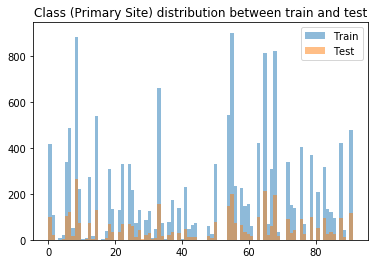

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.hist(Y_train, 92, alpha=0.5, label='Train')
plt.hist(Y_test,  92, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Class (Primary Site) distribution between train and test")
plt.show()

## Select pathway genes for weight regularization

In [18]:
## Use gene set to select for pathways
#gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
#             for name, genes in gene_sets.items()}

gene_keys=gene_sets.keys()
gene_sets['KEGG_GLYCOLYSIS_GLUCONEOGENESIS']

for k,v in gene_sets.items() :
    print(k,v[:10])

KEGG_GLYCOLYSIS_GLUCONEOGENESIS ['ACSS1', 'ACSS2', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH4', 'ADH5', 'ADH6', 'ADH7', 'AKR1A1']
KEGG_CITRATE_CYCLE_TCA_CYCLE ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2']
KEGG_PENTOSE_PHOSPHATE_PATHWAY ['ALDOA', 'ALDOB', 'ALDOC', 'DERA', 'FBP1', 'FBP2', 'G6PD', 'GPI', 'H6PD', 'PFKL']
KEGG_PENTOSE_AND_GLUCURONATE_INTERCONVERSIONS ['AKR1B1', 'CRYL1', 'DCXR', 'DHDH', 'GUSB', 'RPE', 'UGDH', 'UGP2', 'UGT1A1', 'UGT1A10']
KEGG_FRUCTOSE_AND_MANNOSE_METABOLISM ['AKR1B1', 'AKR1B10', 'ALDOA', 'ALDOB', 'ALDOC', 'FBP1', 'FBP2', 'FPGT', 'FUK', 'GMDS']
KEGG_GALACTOSE_METABOLISM ['AKR1B1', 'B4GALT1', 'B4GALT2', 'G6PC', 'G6PC2', 'GAA', 'GALE', 'GALK1', 'GALK2', 'GALT']
KEGG_ASCORBATE_AND_ALDARATE_METABOLISM ['ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH7A1', 'ALDH9A1', 'MIOX', 'UGDH', 'UGT1A1', 'UGT1A10', 'UGT1A3']
KEGG_FATTY_ACID_METABOLISM ['ACAA1', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACADSB', 'ACADVL', 'ACAT1', 'ACAT2', 'ACOX1']
KEGG_STEROID_BIOSYNTHESIS

In [19]:
#all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))



In [20]:
%%time
#read genes pathways in array
# use to create regulation pattern, penalizing weights not in pathway
print("genes:", genes.shape, genes[1:10])

#Assign pathways to weights array
paths= pd.read_table("/home/brad/Downloads/c6.all.v6.1.symbols.gmt"
                     , sep='\t'
                     , header=None
                     , names=range(1000)
                      )
#for each path, mark each weight in neuron with a one if included in pathway
npaths=188 
ngenes = X_train.shape[1]

reg_path = np.zeros((ngenes,npaths))


#for path in range(npaths) :
path=0
for key,pathgenes in gene_sets.items() :
    printf("\npath %s \n %s: ", key, pathgenes)
    for pgene in pathgenes :
        #printf( pgene )
        for w in range (ngenes) :
            #print(genes[w])
            if genes[w] == pgene :
                #printf( 'found gene=%12s, path=%4d w=%5d', genes[w],path,  w )
                reg_path[w,path]=1
    path+=1


reg_path1=np.logical_not(reg_path)+0

#print( reg_path.shape, reg_path)               
#pathcol=paths[0]
#print("paths:",patha.shape,pathcol[1])
#paths.info()


genes: (58581,) ['5_8S_rRNA' '7SK' 'A1BG' 'A1BG-AS1' 'A1CF' 'A2M' 'A2M-AS1' 'A2ML1'
 'A2ML1-AS1']

path KEGG_GLYCOLYSIS_GLUCONEOGENESIS 
 ['ACSS1', 'ACSS2', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH4', 'ADH5', 'ADH6', 'ADH7', 'AKR1A1', 'ALDH1A3', 'ALDH1B1', 'ALDH2', 'ALDH3A1', 'ALDH3A2', 'ALDH3B1', 'ALDH3B2', 'ALDH7A1', 'ALDH9A1', 'ALDOA', 'ALDOB', 'ALDOC', 'BPGM', 'DLAT', 'DLD', 'ENO1', 'ENO2', 'ENO3', 'FBP1', 'FBP2', 'G6PC', 'G6PC2', 'GALM', 'GAPDH', 'GCK', 'GPI', 'HK1', 'HK2', 'HK3', 'LDHA', 'LDHAL6A', 'LDHAL6B', 'LDHB', 'LDHC', 'PCK1', 'PCK2', 'PDHA1', 'PDHA2', 'PDHB', 'PFKL', 'PFKM', 'PFKP', 'PGAM1', 'PGAM2', 'PGAM4', 'PGK1', 'PGK2', 'PGM1', 'PGM2', 'PKLR', 'TPI1']: 

path KEGG_CITRATE_CYCLE_TCA_CYCLE 
 ['ACLY', 'ACO1', 'ACO2', 'CS', 'DLAT', 'DLD', 'DLST', 'FH', 'IDH1', 'IDH2', 'IDH3A', 'IDH3B', 'IDH3G', 'MDH1', 'MDH2', 'OGDH', 'OGDHL', 'PC', 'PCK1', 'PCK2', 'PDHA1', 'PDHA2', 'PDHB', 'SDHA', 'SDHB', 'SDHC', 'SDHD', 'SUCLA2', 'SUCLG1', 'SUCLG2']: 

path KEGG_PENTOSE_PHOSPHATE_PATHWAY 
 ['ALD


path KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION 
 ['ABAT', 'ACAA1', 'ACAA2', 'ACAD8', 'ACADM', 'ACADS', 'ACADSB', 'ACAT1', 'ACAT2', 'ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH6A1', 'ALDH7A1', 'ALDH9A1', 'AOX1', 'AUH', 'BCAT1', 'BCAT2', 'BCKDHA', 'BCKDHB', 'DBT', 'DLD', 'ECHS1', 'EHHADH', 'HADH', 'HADHA', 'HADHB', 'HIBADH', 'HIBCH', 'HMGCL', 'HMGCS1', 'HMGCS2', 'HSD17B10', 'IL4I1', 'IVD', 'MCCC1', 'MCCC2', 'MCEE', 'MUT', 'OXCT1', 'OXCT2', 'PCCA', 'PCCB']: 

path KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_BIOSYNTHESIS 
 ['BCAT1', 'BCAT2', 'IARS', 'IARS2', 'LARS', 'LARS2', 'PDHA1', 'PDHA2', 'PDHB', 'VARS', 'VARS2']: 

path KEGG_LYSINE_DEGRADATION 
 ['AADAT', 'AASDH', 'AASDHPPT', 'AASS', 'ACAT1', 'ACAT2', 'ALDH1B1', 'ALDH2', 'ALDH3A2', 'ALDH7A1', 'ALDH9A1', 'ASH1L', 'BBOX1', 'DLST', 'DOT1L', 'ECHS1', 'EHHADH', 'EHMT1', 'EHMT2', 'GCDH', 'HADH', 'HADHA', 'NSD1', 'OGDH', 'OGDHL', 'PIPOX', 'PLOD1', 'PLOD2', 'PLOD3', 'SETD1A', 'SETD1B', 'SETD2', 'SETD7', 'SETD8', 'SETDB1', 'SETDB2', 'SETMAR', 'SUV39H1', 


path KEGG_ETHER_LIPID_METABOLISM 
 ['AGPS', 'CHPT1', 'ENPP2', 'ENPP6', 'JMJD7-PLA2G4B', 'LPCAT1', 'LPCAT2', 'LPCAT4', 'PAFAH1B1', 'PAFAH1B2', 'PAFAH1B3', 'PAFAH2', 'PLA2G10', 'PLA2G12A', 'PLA2G12B', 'PLA2G1B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2D', 'PLA2G2E', 'PLA2G2F', 'PLA2G3', 'PLA2G4A', 'PLA2G4B', 'PLA2G4E', 'PLA2G5', 'PLA2G6', 'PLA2G7', 'PLD1', 'PLD2', 'PPAP2A', 'PPAP2B', 'PPAP2C']: 

path KEGG_ARACHIDONIC_ACID_METABOLISM 
 ['AKR1C3', 'ALOX12', 'ALOX12B', 'ALOX15', 'ALOX15B', 'ALOX5', 'CBR1', 'CBR3', 'CYP2B6', 'CYP2C18', 'CYP2C19', 'CYP2C8', 'CYP2C9', 'CYP2E1', 'CYP2J2', 'CYP2U1', 'CYP4A11', 'CYP4A22', 'CYP4F2', 'CYP4F3', 'EPHX2', 'GGT1', 'GGT5', 'GGT6', 'GGT7', 'GPX1', 'GPX2', 'GPX3', 'GPX4', 'GPX5', 'GPX6', 'GPX7', 'HPGDS', 'JMJD7-PLA2G4B', 'LTA4H', 'LTC4S', 'PLA2G10', 'PLA2G12A', 'PLA2G12B', 'PLA2G1B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2D', 'PLA2G2E', 'PLA2G2F', 'PLA2G3', 'PLA2G4A', 'PLA2G4B', 'PLA2G4E', 'PLA2G5', 'PLA2G6', 'PTGDS', 'PTGES', 'PTGES2', 'PTGIS', 'PTGS1', 'PTGS2', 'TBXAS1']:


path KEGG_DRUG_METABOLISM_OTHER_ENZYMES 
 ['CDA', 'CES1', 'CES2', 'CES5A', 'CYP2A13', 'CYP2A6', 'CYP2A7', 'CYP3A4', 'CYP3A43', 'CYP3A5', 'CYP3A7', 'DPYD', 'DPYS', 'GMPS', 'GUSB', 'HPRT1', 'IMPDH1', 'IMPDH2', 'ITPA', 'NAT1', 'NAT2', 'TK1', 'TK2', 'TPMT', 'TYMP', 'UCK1', 'UCK2', 'UCKL1', 'UGT1A1', 'UGT1A10', 'UGT1A3', 'UGT1A4', 'UGT1A5', 'UGT1A6', 'UGT1A7', 'UGT1A8', 'UGT1A9', 'UGT2A1', 'UGT2A3', 'UGT2B10', 'UGT2B11', 'UGT2B15', 'UGT2B17', 'UGT2B28', 'UGT2B4', 'UGT2B7', 'UMPS', 'UPB1', 'UPP1', 'UPP2', 'XDH']: 

path KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS 
 ['ACAA1', 'ACOT1', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOX1', 'ACOX3', 'BAAT', 'ELOVL2', 'ELOVL5', 'ELOVL6', 'FADS1', 'FADS2', 'HADHA', 'HSD17B12', 'PECR', 'SCD', 'SCD5', 'TECR', 'YOD1']: 

path KEGG_ABC_TRANSPORTERS 
 ['ABCA1', 'ABCA10', 'ABCA12', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB5', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC1

KeyboardInterrupt: 

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000


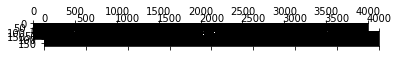

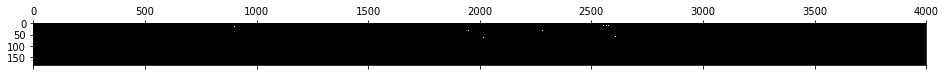

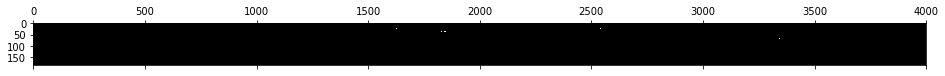

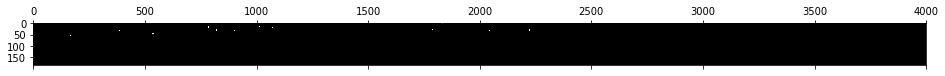

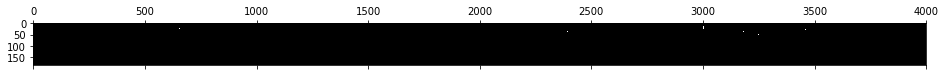

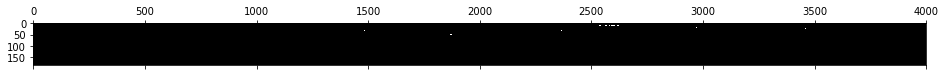

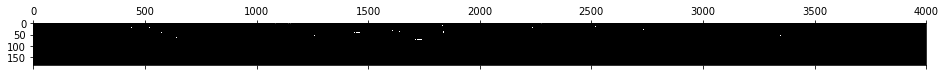

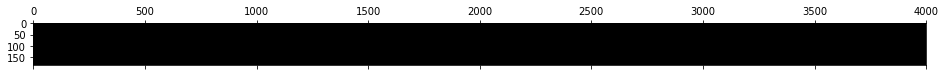

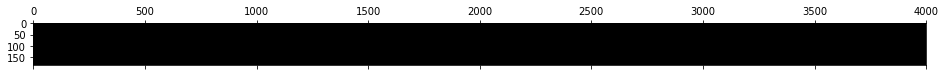

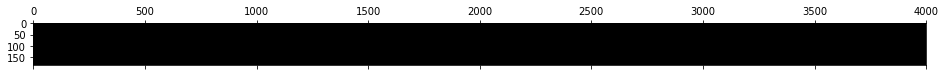

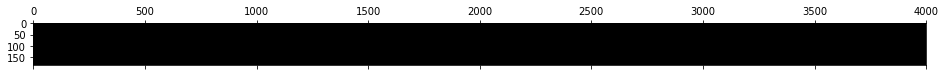

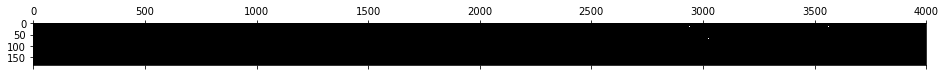

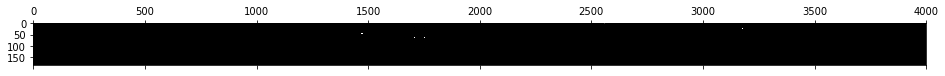

In [21]:
#Show pathways 
for i in range (14) :
    print( i*4000 )               
    plt.matshow(reg_path[i*4000 :i* 4000+4000,:].T, fignum=i, cmap='gray')


In [22]:
#add in some unconstrained neurons by tacking ones onto regpath
npaths_ex= 190
reg_path_ex = np.ones((reg_path.shape[0], npaths_ex-npaths))
print( reg_path .shape, reg_path)  
print( reg_path_ex.shape, reg_path_ex)  
#Tclasses_train=np.concatenate((yall1, yall0), axis=1)

reg_path =np.concatenate((reg_path,reg_path_ex) ,axis=1)
reg_path1=np.logical_not(reg_path)+0
print( reg_path.shape, reg_path)               


(58581, 188) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(58581, 2) [[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]
(58581, 190) [[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [23]:
#initialize weights, gate noise with regularize
from keras import backend as K

def path_init(shape, dtype=None):
    
    return K.random_normal(shape, dtype=dtype)*reg_path



In [24]:
# add regularization to reduce weights not in pathway

from keras import backend as K
def path_norm (weight_matrix) :
#    import numpy as np
#    val = np.random.random((1))
    var = K.variable(value=reg_path)  
#    print("123", weight_matrix.shape)
#    weight_matrix=K.print_tensor(weight_matrix, message='wtf test\n\n')
#    var=print(tf.Print(var, [tf.shape(var)]))
#    return K.sum(K.abs(var))
#    return 0.01 * K.sum(K.abs(weight_matrix*reg_path))
    reg_loss=100*K.sum(K.abs(weight_matrix*reg_path1)) 
    return (reg_loss) 

In [25]:
# if Samples are weighted to equalize class probability during training

sampleweight = False
if sampleweight : sample_weights = class_weight.compute_sample_weight('balanced', Y_train[:])
else : sample_weights = np.ones (Y_train.shape)
print( sample_weights.shape , sample_weights)

(15292,) [1. 1. 1. ... 1. 1. 1.]


In [26]:
"""
Batch normalization with a sparse layer.

Achieves on Test:
3744/3826 [============================>.] - ETA: 0s(['loss', 'acc'], [0.52888519396363787, 0.89388395178336721])
"""
import keras
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
#opt = keras.optimizers.rmsprop(lr=0.000001, decay=1e-6)
#opt = keras.optimizers.adam()


classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    
    #Dense(npaths,kernel_regularizer=path_norm,kernel_initializer=path_init),
    Dense(npaths_ex,kernel_regularizer=path_norm,kernel_initializer=path_init),
    BatchNormalization(),
    Dropout(.5),
    Activation('selu'),

    
    Dense(200),
    BatchNormalization(),
    Dropout(.3),
    Activation('selu'),

    
    Dense(92, activity_regularizer=regularizers.l1(0.0001)),
    Activation('softmax')
]

pathmodel = Sequential(classify)
pathmodel.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy'])

#callbacks=[ TBoard ]
pathmodel.fit(X_train, y_train, epochs=20, batch_size=128, shuffle="true", sample_weight = sample_weights, validation_data=(X_test, y_test))


Train on 15292 samples, validate on 3823 samples
Epoch 1/20
15292/15292 [==============================] - 5s 313us/step - loss: 60177.1222 - acc: 0.1915 - val_loss: 9089.4913 - val_acc: 0.4261
Epoch 2/20
15292/15292 [==============================] - 3s 205us/step - loss: 54842.9709 - acc: 0.3611 - val_loss: 10026.2783 - val_acc: 0.6858
Epoch 3/20
15292/15292 [==============================] - 3s 204us/step - loss: 54839.6860 - acc: 0.4030 - val_loss: 10576.1959 - val_acc: 0.7442
Epoch 4/20
15292/15292 [==============================] - 3s 200us/step - loss: 54834.9362 - acc: 0.4400 - val_loss: 10956.0586 - val_acc: 0.7659
Epoch 5/20
15292/15292 [==============================] - 3s 199us/step - loss: 54829.5068 - acc: 0.4697 - val_loss: 11263.7543 - val_acc: 0.7753
Epoch 6/20
15292/15292 [==============================] - 3s 197us/step - loss: 54823.9341 - acc: 0.5158 - val_loss: 11516.8696 - val_acc: 0.7769
Epoch 7/20
15292/15292 [==============================] - 3s 204us/step - lo

In [27]:
pathmodel.fit(X_train, y_train, epochs=20, batch_size=128, shuffle="true", sample_weight = sample_weights, validation_data=(X_test, y_test))


Train on 15292 samples, validate on 3823 samples
Epoch 1/20
15292/15292 [==============================] - 3s 199us/step - loss: 54732.6880 - acc: 0.7423 - val_loss: 13309.0997 - val_acc: 0.8454
Epoch 2/20
15292/15292 [==============================] - 3s 199us/step - loss: 54726.4568 - acc: 0.7495 - val_loss: 13385.7437 - val_acc: 0.8459
Epoch 3/20
15292/15292 [==============================] - 3s 195us/step - loss: 54720.2482 - acc: 0.7507 - val_loss: 13458.7174 - val_acc: 0.8467
Epoch 4/20
15292/15292 [==============================] - 3s 195us/step - loss: 54713.9938 - acc: 0.7476 - val_loss: 13529.4158 - val_acc: 0.8522
Epoch 5/20
15292/15292 [==============================] - 3s 192us/step - loss: 54707.7378 - acc: 0.7580 - val_loss: 13601.8822 - val_acc: 0.8546
Epoch 6/20
15292/15292 [==============================] - 3s 194us/step - loss: 54701.4968 - acc: 0.7665 - val_loss: 13676.4551 - val_acc: 0.8556
Epoch 7/20
15292/15292 [==============================] - 3s 195us/step - l

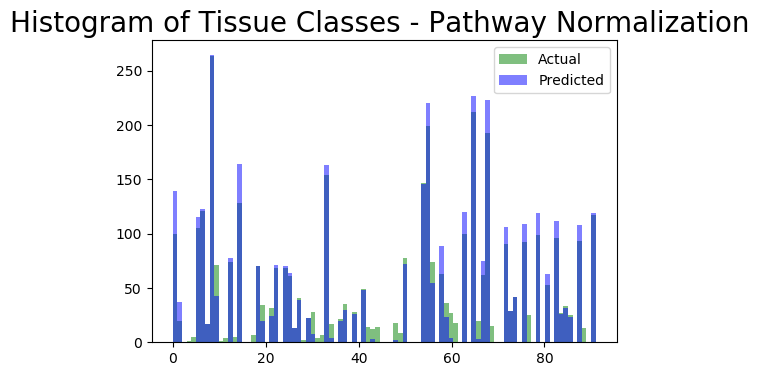

In [28]:
P_test =pathmodel.predict_classes( X_test) 


plt.figure(num=2, dpi=100, frameon=1)
plt.title('Histogram of Tissue Classes - Pathway Normalization ',fontsize = 20)
Y_n, Ybins, Yhist = plt.hist(Y_test[:], 92, facecolor='green', alpha=0.5)
P_n, Ybins, Phist = plt.hist(P_test[:], 92, facecolor='blue',  alpha=0.5)
plt.legend((Yhist[0], Phist[0]), ('Actual', 'Predicted'),fontsize = 10)
plt.show()



## Classify Normal Cell or Tumor Cell (92 bins)


In [29]:
    print('X_train', X_train.shape,'X_test', X_test.shape)
    print('y_train', y_train.shape, 'y_test',y_test.shape)
    print('Y_train', Y_train.shape, 'Y_test', Y_test.shape)


X_train (15292, 58581) X_test (3823, 58581)
y_train (15292, 92) y_test (3823, 92)
Y_train (15292,) Y_test (3823,)


In [30]:
# if Samples are weighted to equalize class probability during training
# suggest setting training opt = keras.optimizers.rmsprop(lr=0.000001, decay=1e-6) to converge


sampleweight = False
if sampleweight==True : sample_weights = class_weight.compute_sample_weight('balanced', Y_train[:])
else : sample_weights = np.ones (Y_train.shape)
print( sample_weights.shape , sample_weights)

(15292,) [1. 1. 1. ... 1. 1. 1.]


In [31]:
"""
Multi-class classification of tumor/normal + primary site with union of genes from all gene sets as input
"""
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
#
classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(500, activation='relu'),
    Dropout(0.8),

    Dense(200, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.6),
    
    Dense(y_train[:,:].shape[1], activation='softmax') 
]

typemodel = Sequential(classify)
print(typemodel.summary())

typemodel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
typemodel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=sample_weights, shuffle="batch",  validation_data=(X_test, y_test))

print(typemodel.metrics_names, typemodel.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               29291000  
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 92)                18492     
Total para

In [32]:

typemodel.fit(X_train, y_train, epochs=100, batch_size=batch_size, sample_weight=sample_weights, shuffle="batch", validation_data=(X_test, y_test))
print(typemodel.metrics_names, typemodel.evaluate(X_test, y_test))

Train on 15292 samples, validate on 3823 samples
Epoch 1/100
15292/15292 [==============================] - 4s 234us/step - loss: 2.1509 - acc: 0.5791 - val_loss: 0.6691 - val_acc: 0.9218
Epoch 2/100
15292/15292 [==============================] - 4s 237us/step - loss: 2.0703 - acc: 0.5995 - val_loss: 0.6516 - val_acc: 0.9200
Epoch 3/100
15292/15292 [==============================] - 4s 233us/step - loss: 1.9932 - acc: 0.6130 - val_loss: 0.6284 - val_acc: 0.9255
Epoch 4/100
15292/15292 [==============================] - 4s 235us/step - loss: 1.8827 - acc: 0.6343 - val_loss: 0.6080 - val_acc: 0.9255
Epoch 5/100
15292/15292 [==============================] - 4s 245us/step - loss: 1.8345 - acc: 0.6405 - val_loss: 0.5862 - val_acc: 0.9283
Epoch 6/100
15292/15292 [==============================] - 4s 237us/step - loss: 1.7850 - acc: 0.6486 - val_loss: 0.5653 - val_acc: 0.9307
Epoch 7/100
15292/15292 [==============================] - 4s 235us/step - loss: 1.7202 - acc: 0.6664 - val_loss: 0.5

15292/15292 [==============================] - 4s 231us/step - loss: 0.8148 - acc: 0.8567 - val_loss: 0.3324 - val_acc: 0.9558
Epoch 60/100
15292/15292 [==============================] - 4s 231us/step - loss: 0.8207 - acc: 0.8580 - val_loss: 0.3343 - val_acc: 0.9553
Epoch 61/100
15292/15292 [==============================] - 4s 231us/step - loss: 0.8198 - acc: 0.8594 - val_loss: 0.3335 - val_acc: 0.9558
Epoch 62/100
15292/15292 [==============================] - 4s 234us/step - loss: 0.8101 - acc: 0.8576 - val_loss: 0.3283 - val_acc: 0.9563
Epoch 63/100
15292/15292 [==============================] - 4s 234us/step - loss: 0.8004 - acc: 0.8607 - val_loss: 0.3288 - val_acc: 0.9550
Epoch 64/100
15292/15292 [==============================] - 4s 232us/step - loss: 0.7980 - acc: 0.8608 - val_loss: 0.3280 - val_acc: 0.9561
Epoch 65/100
15292/15292 [==============================] - 4s 232us/step - loss: 0.7827 - acc: 0.8651 - val_loss: 0.3266 - val_acc: 0.9563
Epoch 66/100
15292/15292 [=======

In [33]:
# impact of sample weights 
P_test  =model.predict_classes( X_test) 
P_train =model.predict_classes( X_train) 


plt.figure(num=2, dpi=100, frameon=1)
plt.title('Histogram of Tissue Classes Train ',fontsize = 20)
Y_n, Ybins, Yhist = plt.hist(Y_train[:], 92, facecolor='green', alpha=0.5)
P_n, Ybins, Phist = plt.hist(P_train[:], 92, facecolor='blue',  alpha=0.5)
plt.legend((Yhist[0], Phist[0]), ('Actual', 'Predicted'),fontsize = 10)
plt.show()


plt.figure(num=3, dpi=100, frameon=1)
plt.title('Histogram of Tissue Classes Test ',fontsize = 20)
Y_n, Ybins, Yhist = plt.hist(Y_test[:], 92, facecolor='green', alpha=0.5)
P_n, Ybins, Phist = plt.hist(P_test[:], 92, facecolor='blue',  alpha=0.5)
plt.legend((Yhist[0], Phist[0]), ('Actual', 'Predicted'),fontsize = 10)
plt.show()



NameError: name 'model' is not defined

## Augment data 
This algorithm creates a new training set by mixing two samples together. 
* A small random percentage of sample B is mixed in with sample A. 
* The label is still A
* Seems to help speed up convergence and acts to prevent overfitting


In [ ]:
model=pathmodel
model=typemodel
sampleweight=False
if sampleweight==True : sample_weights = class_weight.compute_sample_weight('balanced', Y_train[:])
else                  : sample_weights = np.ones (Y_train.shape)
print( 'sample weights', sample_weights.shape , sample_weights)



import numpy as np
def RNA_mix(mix, naug):
    
#    print( X_train.shape[0] )
    rmix=np.random.rand()*(1-mix)
#    print(mix, 1-rmix)

    samples=X_train.shape[0]
    for i in range(naug) :
        i0 = np.random.randint(samples)
        i1 = np.random.randint(samples)
        X_mix0 = X_train[i0,:] *(1-rmix) 
        X_mix1 = X_train[i1,:] *(  rmix)
        
        #print(i0,i1 )
        #print(X_train[i0, 0:5] )
        #print(X_train[i1, 0:5] )
        #print(Xmix0[0:5] )
        #print(Xmix1[0:5] )
        X_aug[i,:]= X_mix0 + X_mix1
        y_aug[i,:]= y_train[i0,:]
        Y_aug[i]  = Y_train[i0]
        
naug=5000
X_aug =np.zeros((naug,X_train.shape[1]))
y_aug =np.zeros((naug,y_train.shape[1]))
Y_aug =np.zeros((naug))



#RNA_mix(.4, naug)  

for k in range(10):
    for i in range(10):
        if sampleweight==True : sample_weights_aug = class_weight.compute_sample_weight('balanced', Y_aug[:])
        else                  : sample_weights_aug = np.ones (Y_aug.shape)
        #print( 'sample weights', sample_weights_aug.shape , sample_weights)

        RNA_mix(.8, naug)   
        model.fit(X_aug, y_aug, epochs=1, batch_size=128, shuffle="true",sample_weight = sample_weights_aug,validation_data=(X_test, y_test))

    model.fit(X_train, y_train, epochs=5, batch_size=256, shuffle="true",sample_weight = sample_weights,validation_data=(X_test, y_test))


# Visualize the Results

In [ ]:
from   plotly.offline    import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from   sklearn.metrics   import confusion_matrix

#Matplotlib inline
%matplotlib inline

# run at the start of every ipython notebook to use plotly.offline
# this injects the plotly.js source files into the notebook
init_notebook_mode(connected=True) 


## Show the Histogram

In [ ]:
#
model=typemodel
P_test =model.predict_classes( X_test) 


plt.figure(num=2, dpi=100, frameon=1)
plt.title('Histogram of Tissue Classes ',fontsize = 20)
Y_n, Ybins, Yhist = plt.hist(Y_test[:], 92, facecolor='green', alpha=0.5)
P_n, Ybins, Phist = plt.hist(P_test[:], 92, facecolor='blue',  alpha=0.5)
plt.legend((Yhist[0], Phist[0]), ('Actual', 'Predicted'),fontsize = 10)
plt.show()


## Show the Confusion Matrix

In [ ]:
#import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
P_test =model.predict_classes( X_test) 

cm = confusion_matrix(Y_test[:], P_test[:], labels=np.arange(92))

plt.figure(num=1, dpi=100, frameon=1)
plt.matshow(np.log(cm+1), fignum=1, cmap='jet')
plt.title('Confusion matrix of Tissue Classes (>46=with Tumor)',fontsize = 16)
plt.xlabel('Predicted Class',fontsize = 14)
plt.ylabel('Actual Class',fontsize = 14)
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8, rotation=00)
plt.colorbar()
plt.show()

## Show Normalized Confusion matrix using Plotly 

In [ ]:
labels =[      class_labels[i] for i in range(46)]
labels+=['T_'+ class_labels[i] for i in range(46)]
#print('labels =', labels)

#Normalize rows 
cmp=cm[:,:]*1.000
for row in range(92) :
    if Y_n[row] != 0 :  
        for col in range(92) :
            cmp[row, col] = cm[row,col]/Y_n[row]
        #print('Y_n', row, Y_n[row], cm [row,0:46], cmp[row,0:46])



trace = go.Heatmap(
    z=cmp,
    x=labels,
    y=labels,
    ygap=1,
    xgap=0,
    colorscale=[
        [0.0,   'rgb(  0, 30,100)'], 
        [0.01,  'rgb( 50, 50, 150)'], 
        [0.02,  'rgb( 50,100, 200)'], 
        [0.04,  'rgb(100,100, 150)'], 
        [0.1,   'rgb(250,100,100)'], 
        [0.5,   'rgb(200,250,200)'], 
        [1.0,   'rgb(255,250,255)']]
 

)
data=[trace]


layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title='Confusion Matrix',
    xaxis=dict(
        title='Predicted',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    ),
    yaxis=dict(
        title='Actual',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        )
    )


)
fig = go.Figure(data=data, layout=layout)
plot_url = plot(fig, filename='normalized confusion-matrix.html')


trace = go.Heatmap(
    z=cmp,
    x=labels,
    y=labels,
    ygap=0,
    xgap=0,
    colorscale=[
        [0.0,   'rgb(  0, 30,100)'], 
        [0.01,  'rgb( 50, 50, 150)'], 
        [0.02,  'rgb( 50,100, 200)'], 
        [0.04,  'rgb(100,100, 150)'], 
        [0.1,   'rgb(250,100,100)'], 
        [0.5,   'rgb(200,250,200)'], 
        [1.0,   'rgb(255,250,255)']]
 

)
data=[trace]

iplot(data, filename='normalized confusion matrix')


## Visualize the Weights

In [ ]:
model= pathmodel
model.summary()

if(1):
    x=model.get_weights()

    
    #x=get_weights()
    print("\n weight list" )
    for i in range(2) :
        print("weight", i, x[i].shape, x[i] )
    print("layers=", model.layers)
    print("inputs=", model.inputs)
    print("outputs=", model.outputs)


In [ ]:
w=model.layers[2].get_weights()
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    #print(weights)
    
print(type(w[0]), type(w[1]), w[0].shape, w[1].shape)

In [ ]:
#show the weights

w0=w[0]
plt.matshow(w0[0:1000,:].T, fignum=1, cmap='gray')
#plt.matshow(np.log(w0[0:1000,0:].T), fignum=2, cmap='jet')


## Show the input X 

In [ ]:
import matplotlib.pyplot as plt


x1=X_train[0:, 0:]
print(x1.shape)


xavg=np.average(x1, axis=1)
print("X_sum.shape:", x1.shape, xavg)
plt.figure(num=1, dpi=100, frameon=1)
n, bins, patches = plt.hist(xavg, 100, facecolor='blue', alpha=0.8)
plt.show()


for i in range (1) :
    print('s=', i*4000)
    plt.figure(num=i+2, dpi=100, frameon=1, figsize=(10, 10))
    plt.matshow(x1[0:4000, i*4000:i*4000+4000], fignum=i+2, cmap='gray')    

smax=np.amax(x1[0:, 0:])
smin=np.amin(x1[:,:])
print(smin, smax)

x2 =(x1-smin)/(smax-smin)
smax=np.amax(x2[0:, 0:])
smin=np.amin(x2[:,:])
print(smin, smax)

x1=0
x2=0

## Show sorted input X 

set up sort

In [ ]:
# Plot the raw input data as a heatmap 
# select rows and reorder matrix so similar rows and cols are next to each other


from scipy.cluster.hierarchy import dendrogram, linkage

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
#method='single' #fast (causes recursion bug in dendrogram??)
#method='complete' # very slow
#method='average' #fast
#method='weighted' #fast
method='centroid' #fast
#method='median' #fast
#method='ward' #slow


# sort and select parameters
o_samples = 0000  # row start in data 
n_samples = 3500  # number of rows
#n_samples =  190  # number of rows
n_rna     = 324  # number of rnaseqs
#n_rna     = 2000  # number of rnaseqs

o_rna     = 0     # rnaseq sstart in data
visualize = 'RNA'
#visualize = 'weights'

pathway_rnas  = True
random_rnas   = True
sortrow    = True
sortcol    = True
showtest   = True
showtrain  = not showtest

# select classes to sort -- This is where we select the classes to show
class_sort  = list(range(92))
#class_sort  = list(range(0,46))
#class_sort  = [8, 46+8,]
class_sort  = [9,21,22,23, 9+46,21+46,22+46,23+46]



all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
pathway_sort = all_gene_set_genes
pathway_sort = genes
pathway_sort = gene_sets['KEGG_PATHWAYS_IN_CANCER'][:]


n_classes    = len(class_sort)
printf('Select the following %d classes to sort %s:',n_classes, class_sort)
printf('Select random set %d of  %d genes in pathway to sort %s:',n_rna, len(pathway_sort), pathway_sort[0:10])



In [ ]:
#gene_sets.items[0:10]
#[ 'KEGG_PATHWAYS_IN_CANCER' ]

#for key,pathgenes in gene_sets.items() :
 #   printf("\npath %s \n %s: ", key, pathgenes)
#gene_sets['KEGG_PATHWAYS_IN_CANCER'][:]
for i in range(92) : print(i, labels[i])

In [ ]:
%%time
# get predicted and actual classes and data sizes

if(showtrain==True) :
    #print('Show Training Results')
    classes_pred  = model.predict_classes( X_train)
    classes_id    = Y_train
    t_rna     = X_train.shape[1] 
    t_samples = X_train.shape[0]
        
    
if(showtest==True) :
    #print('Show Test Results')
    classes_pred  = model.predict_classes( X_test)
    classes_id    = Y_test
    t_rna     = X_test.shape[1] 
    t_samples = X_test.shape[0]


# identify the samples which contain the selected classes 

samples=[]
for k in range(n_classes) :
    for i in range (n_samples) :
        if(class_sort[k]==classes_id[i]) : 
            samples.append(i)
f_samples=len(samples)
printf('found %d samples = %s', f_samples, samples[0:8] )
print('samples\n', X_train[samples[0:4],0:8] )



# identify the gene locationas which contain the selected genes 


n_genes = len (pathway_sort)
gene_locs=[]
for k in range(n_genes) :
    for i in range (t_rna) :
        if(pathway_sort[k]==genes[i]) : 
            gene_locs.append(i)
f_genes=len(gene_locs)

printf('found %d genes = %s', f_genes, gene_locs[0:8] )
print('genes\n', X_train[samples[0:8], gene_locs[0:8] ] )

In [ ]:
#add id to gene for tracking
#---------------------------------------------------------------

gene_labels=np.array([ pathway_sort[i]+'_'+ str(i)  for i in range(f_genes)])
#print('gene_labels\n',type(gene_labels ), gene_labels.shape, gene_labels [:8]  )
#print('genes\n',type(genes ), genes.shape, genes [:8]  )


In [ ]:
# now select the input data for the identified samples and genes
#---------------------------------------------------------------
if(visualize=='weights') : w1=w0     [:,:].T    
if(visualize=='RNA' and showtrain==True) :     w1=X_train[samples,:]       
if(visualize=='RNA' and showtest ==True) :     w1=X_test [samples,:]       

w1=w1[:,gene_locs]    
    
print('w1\n', w1.shape,'\n', w1[0:4, 0:8]  )
    
     

In [ ]:
#create the class labels
#---------------------------------------------------------------

#select subset of labels
class_pred  = classes_pred[samples]
class_id    = classes_id  [samples]
class_label=[ labels[class_id[i]]+'_'+ str(i)  for i in range(f_samples)]




# create labels with predicted and actual value if different
n_err=0 
for i in range(f_samples) :
    if(class_id[i]!=class_pred[i]) :
        class_label[i] ='Pred='+  labels[class_pred[i]] + ' True=' + class_label[i]
        n_err+=1

print()
print('act =', class_id    [0:20]    )
print('pred=', class_pred  [0:20])
printf('found %d errs in %d samples, accuracy = %2.2f', n_err, f_samples, 1-n_err/f_samples)
print('labels', class_label[0:10])

In [ ]:

# Select a window of RNA genes
if(random_rnas==False) :  
    w2 = w1[o_samples:o_samples+n_samples,o_rna:o_rna+n_rna]
    rnaseq_id=gene_labels[o_rna:n_rna+o_rna]



# Select a random subset of RNA genes
if(random_rnas==True) :
    rnas=np.random.permutation(np.arange(f_genes))
    rnas=rnas[:n_rna]
    rnaseq_id=gene_labels[rnas]
    w2 = w1[:,rnas]

print('f_genes',f_genes, 'n_rna',n_rna, 'rnas', rnas.shape, max(rnas)  )


print('rnaseq_id\n',len(rnaseq_id ), rnaseq_id [:8]  )
print('X_train\n',X_train.shape,'\n', X_train[0:4, 0:8])  
print('w1\n',w1.shape, '\n',w1[0:4, 0:8])  
print('w2\n',w2.shape, '\n',w2[0:4, 0:8])  

In [ ]:
%%time
#Sort matrix
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
#method='single' #fast (causes recursion bug in dendrogram??)
#method='complete' # very slow
#method='average' #fast 1m 29s
#method='weighted' #fast 14m 43s
#method='centroid' #fast 1m1s
#method='median' #fast 1m3s
method='ward' #slow 27m


if(sortrow==False) : 
    w3=w2.T
    sample_labels_permuted=[ class_label[i]  for i in range(f_samples)]

if(sortrow==True)  :
    Z = linkage(w2, method=method, optimal_ordering=True)
    dn = dendrogram(Z,no_plot=True)
    sample_leaf_order=dn['leaves']
    w3=w2[sample_leaf_order,:].T
    sample_labels_permuted=[ class_label[sample_leaf_order[i]]  for i in range(f_samples)]

    
    
print('w3\n',w3.shape,  w3[0:4, 0:4])
print('samp',len(sample_leaf_order), n_samples,'\n', sample_leaf_order[0:10], '\n',sample_labels_permuted[0:10])

#create labels for reordered samples
if(sortcol==False) :
    w4=w3.T
    rna_labels_permuted=[ rnaseq_id[i] for i in range(n_rna)]
if(sortcol==True ) :  
    Z  = linkage(w3, method=method, optimal_ordering=True)
    dn = dendrogram(Z,no_plot=True)
    rna_leaf_order=dn['leaves']
    w4 = w3[rna_leaf_order,:].T 
    rna_labels_permuted=[ rnaseq_id[rna_leaf_order[i]] for i in range(n_rna)]

print('w4\n',w4.shape,w4[0:4, 0:4])
print('rna',len(rna_leaf_order),'\n', n_rna, rna_leaf_order[0:10], '\n',rna_labels_permuted[0:10])


In [ ]:
# now plot the data
#----------------------------------------------------------
if(visualize=='RNA'): # scale to 0-1
    smax=np.amax(w4[0:, 0:])
    smin=np.amin(w4[:,:])
    print('initial data range', smin, smax)
    
    w5 =(w4-smin)/(smax-smin)
    smax=np.amax(w5[0:, 0:])
    smin=np.amin(w5[:,:])
    print('scaled data range', smin, smax)
    w6=w5
    colorscale=[
        [ 0.0,  'rgb( 20, 20, 10)'], 
        [ 0.1,  'rgb( 50, 50,200)'], 
        [ 0.2,  'rgb( 50,200,200)'], 
        [ 0.4,  'rgb(200, 50, 50)'], 
        [ 0.5,  'rgb(30,20, 10)'], 
        [ 0.7,  'rgb(200,200, 50)'], 
        [ 0.8,  'rgb( 50,255, 50)'],
        [ 1.0,  'rgb(255,255,255)']]  
    map_title="RNA -"  + method
    xaxis_title='RNA Sequence'
    yaxis_title='Sample'



if(visualize=='weights') : #scale to +1 -1
    smax=np.amax(w4[0:, 0:])
    smin=np.amin(w4[:,:])
    print('initial data range', smin, smax)
    
    ssmax=max(smax, -smin)
    w5 =(w4)/(ssmax)/2+.5
    smax=np.amax(w5[0:, 0:])
    smin=np.amin(w5[:,:])
    print('scaled data range', smin, smax)
    w6=w5

    colorscale=[
        [ 0.0,  'rgb( 50,255, 50)'], 
        [ 0.2,  'rgb( 50,100, 50)'], 
        [ 0.3,  'rgb( 20, 50, 20)'], 
        [ 0.4,  'rgb( 10, 20, 10)'], 
        [ 0.5,  'rgb(  0,  0,  0)'], 
        [ 0.6,  'rgb( 20, 10, 10)'], 
        [ 0.7,  'rgb( 50, 20, 20)'],
        [ 0.8,  'rgb(100, 50, 50)'],
        [ 1.0,  'rgb(255, 50, 50)']]
    map_title="Layer1 Weights"
    xaxis_title='RNA Sequence'
    yaxis_title='Neuron ID'



trace = go.Heatmap(
    z=w6[0:, 0:],
    y=sample_labels_permuted,
    x=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 1000,
    height= 750,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')

# Distance matrix for selected genes and tissues

## Sample-to-Sample Distance

In [ ]:
%%time
from scipy.spatial.distance import pdist, squareform

#cols = [col for col in df.columns if col not in ['breadth', 'uniprot_id', 'avg']]
#short_cols = [col[0:20] for col in cols]
#short_cols = [short_cols[i] + str(i) for i in range(1,len(short_cols),1)]
sample_dist = pdist(w6[:, :])

In [ ]:
#print (data_dist.shape, data_dist)
sample_sq=squareform(sample_dist)
#print (data_sq.shape, data_sq)


In [ ]:
map_title="Sample to Sample distance -"  

xaxis_title='Sample'
yaxis_title='Sample'



trace = go.Heatmap(
    z=sample_sq[:,:],
    x=sample_labels_permuted,
    y=sample_labels_permuted,
#    x=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 750,
    height= 750,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')

## Gene-to-Gene Distance

In [ ]:
%%time

#distance metrics
#'euclidean'
#'minkowski', p=2.
#'cityblock'
#'seuclidean'
#'sqeuclidea'
#'cosine'
#'correlation'
#'hamming'
#'jaccard'
#'chebyshev'
#'canberra
#'braycurtis'
#'mahalanobis'
distance = 'cosine'
distance = 'seuclidean'
distance = 'correlation'
#distance = 'hamming'
#distance = 'jaccard'
#distance = 'chebyshev'
#distance ='canberra'
#distance ='braycurtis'
##distance ='mahalanobis'
#distance ='euclidean'


from scipy.spatial.distance import pdist, squareform
rna_dist = pdist(w6.T[:, :],distance)
rna_sq=squareform(rna_dist)

map_title="RNA distance -"  + distance

xaxis_title='RNA Gene'
yaxis_title='RNA Gene'



trace = go.Heatmap(
    z=rna_sq[:,:],
#    x=sample_labels_permuted,
#    y=sample_labels_permuted,
    x=rna_labels_permuted,
    y=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 750,
    height= 750,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')



## Covariance

In [ ]:
%%time
#covariance


cov_matrix = np.cov(w6.T[:, :])

map_title="RNA distance -"  + 'covariance'

xaxis_title='RNA Gene'
yaxis_title='RNA Gene'

colorscale=[
        [ 0.00,  'rgb( 50,255,255)'], 
        [ 0.29,  'rgb( 50,100,100)'], 
        [ 0.31,  'rgb( 10, 10, 10)'], 
        [ 0.33,  'rgb(100, 50, 50)'],
        [ 0.50,  'rgb(255, 50, 50)'],
        [ 1.00,  'rgb(255,255,255)']]




trace = go.Heatmap(
    z=cov_matrix,
#    x=sample_labels_permuted,
#    y=sample_labels_permuted,
    x=rna_labels_permuted,
    y=rna_labels_permuted,
    ygap=0,
    xgap=0,
    colorscale=colorscale
    )
data=[trace]


layout = go.Layout(
    autosize=False,
    width = 750,
    height= 750,
    margin=dict(
        l=150,
        r=100,
        b=150,
        t=100,
        pad=4
    ),
    paper_bgcolor='#ffffff',
    plot_bgcolor='#000000' ,
    title=map_title,
    xaxis=dict(
        title=xaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),
        showticklabels=True,
        tickangle=90,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
   ),
    yaxis=dict(
        #scaleanchor = "x",
        title=yaxis_title,
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#000000'
        ),

        showticklabels=True,
        tickangle=0,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=6,
            color='black'
        ),
    ),
)
fig = go.Figure(data=data, layout=layout)

plot_url = plot(fig, filename=map_title + '.html')



In [ ]:
## Network from Covariance

In [ ]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# I build a data set: 10 individuals and 5 variables for each
ind1=[5,10,3,4,8,10,12,1,9,4]
ind5=[1,1,13,4,18,5,2,11,3,8]
df = pd.DataFrame({ 'A':ind1, 'B':ind1 + np.random.randint(10, size=(10)) , 'C':ind1 + np.random.randint(10, size=(10)) , 'D':ind1 + np.random.randint(5, size=(10)) , 'E':ind1 + np.random.randint(5, size=(10)), 'F':ind5, 'G':ind5 + np.random.randint(5, size=(10)) , 'H':ind5 + np.random.randint(5, size=(10)), 'I':ind5 + np.random.randint(5, size=(10)), 'J':ind5 + np.random.randint(5, size=(10))})
df
 
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
corr = df.corr()
corr
 
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.8) & (links['var1'] != links['var2']) ]
links_filtered
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'var1', 'var2')
 
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)
